In [1]:
%run ../../_setup.py

from netCDF4 import Dataset
import xarray

import numpy as np

import pygmt
# from gmt import Figure

from OceanPy.readwrite import readxyz

from scipy.interpolate import griddata
import cmocean as cmo

# Bathymetry (Smith and Sandwell, 1997)

In [3]:
# input_file = os.path.join(datadir, 'external', 'bathymetry', 'smith_and_sandwell_1997', 'bathymetry_-48_137_-58_157.nc')
input_file = os.path.join(datadir, 'external', 'bathymetry', 'bodc_res30sec', 'GEBCO_2014_2D_137.0_-58.0_147.0_-48.0.nc')
bathy = xarray.open_dataset(input_file)

# boundaries
north = -52.4
west = 137
south = -48
east = 147

# dep = bathy.depth.sel(longitude=slice(west, east), latitude=slice(north, south))
dep = bathy.elevation.sel(lon=slice(west, east), lat=slice(north, south))
depths = np.linspace(-5000, 0, 11)


# x, y, z = readxyz(os.path.join(datadir, 'external', 'bathymetry', 'smith_and_sandwell_1997_137_-52.4_147_-48.xyz'))

# # grid  1 minute
# loni = np.linspace(137, 147, 60*(147-137)+1)
# lati = np.linspace(-48, -52.4, int(60*(-48 + 52.4)+1))

# lonlon, latlat = np.meshgrid(loni, lati)
# elev = griddata((x, y), z, (lonlon, latlat), method='linear')

# fig, ax = plt.subplots(2, 1)
# ax[0].scatter(x, y, c=z)
# ax[1].pcolor(lonlon, latlat, np.ma.masked_invalid(elev))


# Sea surface heights and derived variables
http://marine.copernicus.eu/services-portfolio/access-to-products/?option=com_csw&view=details&product_id=SEALEVEL_GLO_PHY_L4_REP_OBSERVATIONS_008_047


TODO: open different ssh rep file and make selection of data from 136.5, such that ssh contours cover the whole figure

In [4]:
input_file = os.path.join(datadir, 'external', 'ssh', 'rep', 'SEALEVEL_GLO_PHY_L4_REP_OBS_137_-52.4_147_-48_199801-199812.nc')

# Select data over time of the voyage
SSH = xarray.open_dataset(input_file)
SSHvoyage = SSH.sel(time=slice('1998-03-10', '1998-03-28'))

# Mean Absolute Dynamic Topography (ADT) over time of voyage
voyagemeanadt = SSHvoyage.mean('time')['adt']

# Weekly mean ADT
weeks = np.unique(SSHvoyage.time.dt.week)
weekmeanadt = SSH.groupby('time.week').mean('time')['adt'][weeks-1]

print(voyagemeanadt.shape, weekmeanadt.shape)

(19, 41) (3, 19, 41)


# CTD stations SS9802 and SR3 stations AA9802

In [2]:
input_file = os.path.join(datadir, 'processed', 'ss9802', 'ctd', 'ss9802_ctd.nc')
ctd = Dataset(input_file)

input_file = os.path.join(datadir, 'processed', 'aa9802', 'aa9802_ctd.nc')
sr3 = Dataset(input_file)

# plt.plot(ctd['lon'][:,1], ctd['lat'][:,1], color='k', zorder=0)
# plt.scatter(ctd['lon'][:,1], ctd['lat'][:,1], edgecolor='k', facecolor='w', zorder=1)


In [3]:
sr3.variables.keys()

odict_keys(['country', 'WOD_cruise_identifier', 'wod_unique_cast', 'lat', 'lon', 'time', 'date', 'GMT_time', 'Access_no', 'Platform', 'Institute', 'Orig_Stat_Num', 'Bottom_Depth', 'Cast_Duration', 'High_res_pair', 'dataset', 'z', 'z_WODflag', 'z_sigfigs', 'z_row_size', 'Temperature', 'Temperature_sigfigs', 'Temperature_row_size', 'Temperature_WODflag', 'Temperature_WODprofileflag', 'Temperature_Scale', 'Temperature_Instrument', 'Salinity', 'Salinity_sigfigs', 'Salinity_row_size', 'Salinity_WODflag', 'Salinity_WODprofileflag', 'Salinity_Scale', 'Salinity_Instrument', 'Pressure', 'Pressure_sigfigs', 'Pressure_row_size', 'Chlorophyll', 'Chlorophyll_sigfigs', 'Chlorophyll_row_size', 'Chlorophyll_WODflag', 'Chlorophyll_WODprofileflag', 'Chlorophyll_Instrument', 'Chlorophyll_uncalibrated', 'crs'])

In [128]:

from netCDF4 import num2date
# help(num2date)


<IPython.core.display.Javascript object>


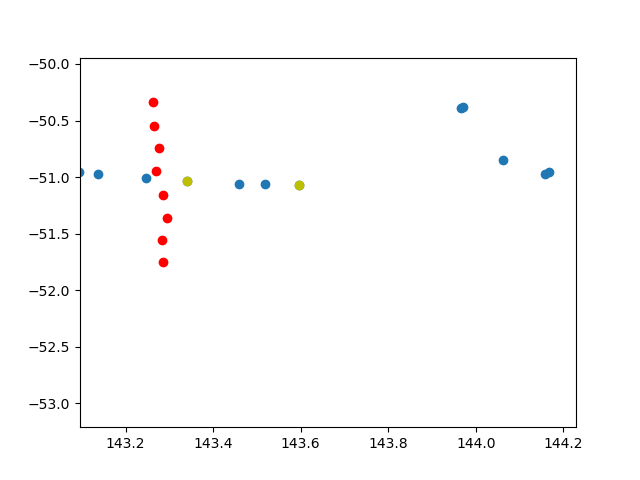

In [134]:

import matplotlib.pyplot as plt
%matplotlib notebook

npmax = 751# 751, 1006

time = num2date(sr3['time'][:], sr3['time'].units)
stations = np.where(sr3['Pressure_row_size'][:] > npmax)[0]

nplevels = sr3['Pressure_row_size'][:]
# nstations, npmax = len(stations), max(nplevels)

t = np.ma.masked_all((len(nplevels), max(nplevels)))
p, SP = t.copy(), t.copy()
for ist, ip in enumerate(nplevels):
    i = np.sum(nplevels[:ist])
    ii = np.sum(nplevels[:ist+1])

    t[ist, :ip] = sr3['Temperature'][i:ii]
    p[ist, :ip] = sr3['Pressure'][i:ii]
    SP[ist, :ip] = sr3['Salinity'][i:ii]

plt.scatter(sr3['lon'][:], sr3['lat'][:])
plt.scatter(ctd['lon'][:,0], ctd['lat'][:,0], facecolors='r')
plt.scatter(sr3['lon'][stations], sr3['lat'][stations], facecolors='y')



In [131]:
nplevels[stations]

masked_array(data=[1004, 2269, 2005, 1003, 1002,  994, 2248, 1004, 2257,
                   2006, 1002, 1989, 1006, 1535, 1415, 1560, 1004, 1001,
                   1000, 1002, 1910, 1979],
             mask=False,
       fill_value=999999,
            dtype=int32)

<IPython.core.display.Javascript object>


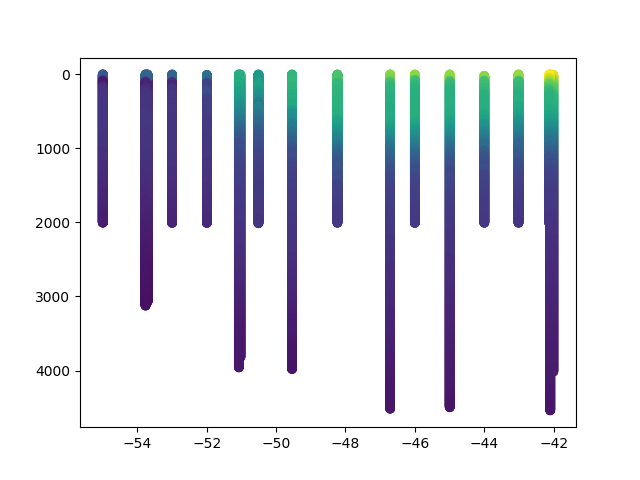

In [133]:
lat = np.broadcast_to(sr3['lat'][:][:, np.newaxis], t.shape)

fig, ax = plt.subplots()
ax.scatter(lat[stations,], p[stations,], c=t[stations,])
ax.invert_yaxis()


# Orsi et al. 1995 fronts

In [5]:
orsi = {}
fronts = {'stf': 'tomato', 'saf': 'skyblue', 'pf': 'royalblue'}
for front in fronts.keys():
    input_file = os.path.join(datadir, 'external', 'orsi', front + '.txt')
    lon, lat = zip(*np.genfromtxt(input_file, delimiter='   ', comments='%'))
    orsi[front] = [lon, lat]


In [6]:
# lnln, ltlt = np.meshgrid(dep.longitude, dep.latitude)
# np.diff(dep.longitude)
# grid = gmt.datasets.load_earth_relief(resolution='30m')
dep

<xarray.DataArray 'elevation' (lat: 528, lon: 1200)>
[633600 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -52.4 -52.39 -52.38 -52.37 -52.36 -52.35 -52.35 ...
  * lon      (lon) float64 137.0 137.0 137.0 137.0 137.0 137.0 137.1 137.1 ...
Attributes:
    standard_name:       height_above_reference_ellipsoid
    long_name:           Elevation relative to sea level
    units:               m
    sdn_parameter_urn:   SDN:P01::BATHHGHT
    sdn_parameter_name:  Sea floor height (above mean sea level) {bathymetric...
    sdn_uom_urn:         SDN:P06:ULAA
    sdn_uom_name:        Metres

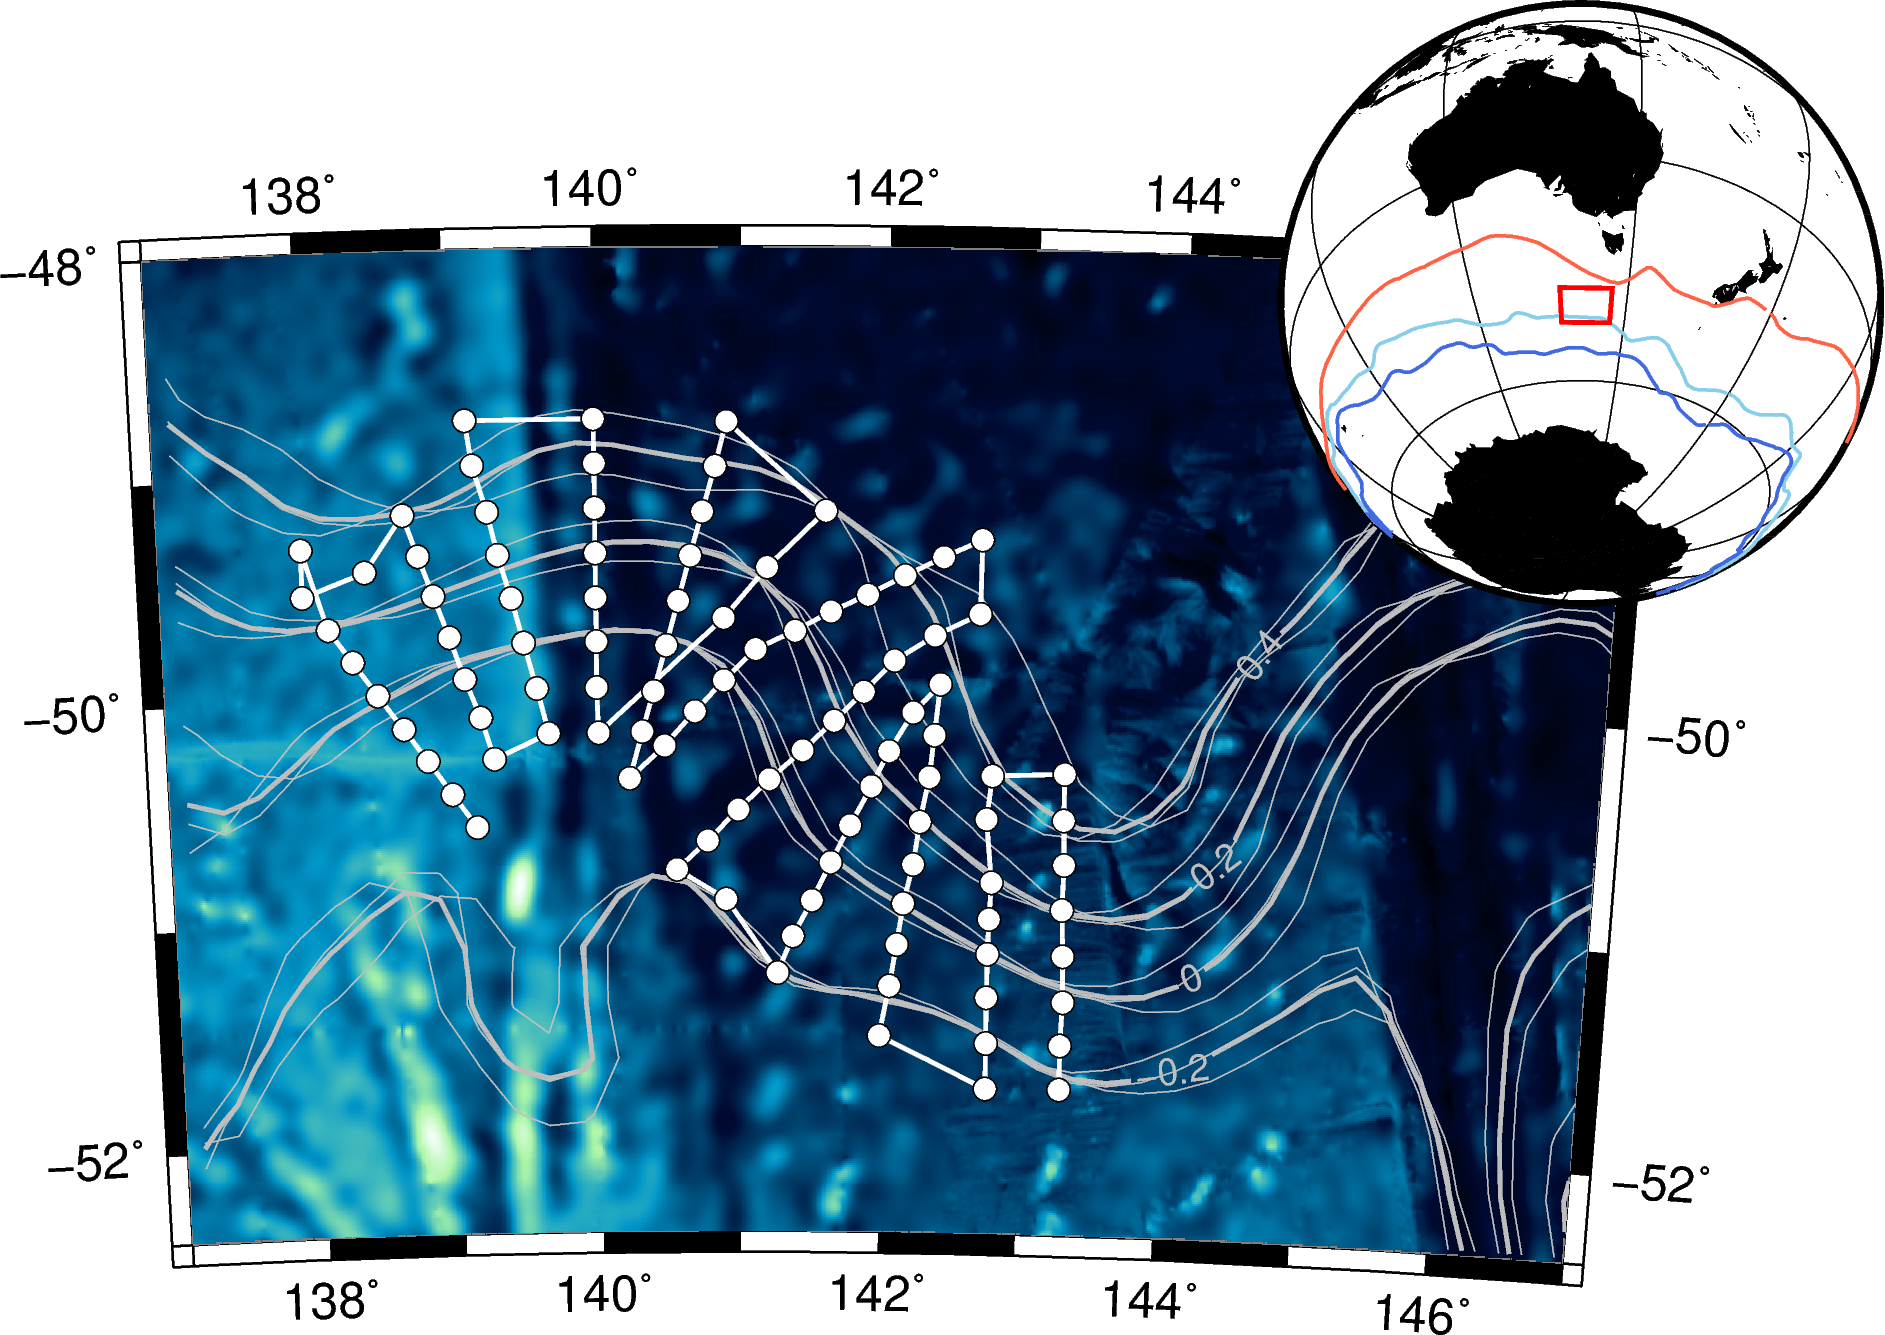

In [7]:
fig = pygmt.Figure()
fig.coast(region=[137, 147, -52.4, -48], projection='B141/-51/-50/-49/5i', land='chocolate', water='skyblue', frame=True)
# fig.contour(lnln.flatten(), ltlt.flatten(), dep.data.flatten(), pen='1p,black')
fig.grdimage(dep, projection='B141/-51/-50/-49/5i', region=[137, 147, -52.4, -48], cmap='ocean')#, shading='+a120+nt1.5')
for i in range(weekmeanadt.shape[0]):
    fig.grdcontour(weekmeanadt[i], interval=0.2, annotation='-', limit=[-0.2, 0.4], pen='gray')
fig.grdcontour(voyagemeanadt, interval=0.2, annotation=0.2, label_placement='l144/52S/145/48S', limit=[-0.2, 0.4], pen='1p,gray')
fig.plot(x=ctd['lon'][2:,0], y=ctd['lat'][2:,0], pen='1p,white')
fig.plot(x=ctd['lon'][2:,0], y=ctd['lat'][2:,0], style='c0.2c', color='white', pen='black')
fig.coast(region="g", projection="G141/-50.1/10000/0/0/0/0/0/2i", land="black", water='white', frame='afg', X='3.8i', Y='2.2i')
for front in fronts.keys():
    fig.plot(orsi[front][0], orsi[front][1], pen='0.75p,%s' %fronts[front])
fig.plot([137.0, 147.0, 147.0, 137.0, 137.0], [-52.4, -52.4, -48.0, -48.0, -52.4], pen='1p,red')
# colorbar pygmt.makecpt
fig.show(dpi=300, width=1000)

In [9]:
extensions = ['.png', '.pdf', '.eps']
for extension in extensions:
    fig.savefig(os.path.join(figsdir, 'manuscripts', '01_manuscript', '01_overview-map' + extension))